# Машинное обучение для текстов. Обучение модели классифицировать комментарии на позитивные и негативные

### Описание
Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

### Цель
Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

### План по выполнению проекта

1. Загрузка и подготовка данных
2. Обучение несколько моделей
3. Выводы

### Описание данных

Данные находятся в файле с признаком "комментарий" и целевым признаком "0", "1".

# 1. Загрузка и подготовка данных

Импортируем необходимые библиотеки для работы

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Загрузим и выведем информацию о данных

In [ ]:
df = pd.read_csv('toxic_comments.csv')

In [ ]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
print('Количество дублирующихся строк:', df.duplicated().sum())

Количество дублирующихся строк: 0


Проверим баланс классов

Соотношение классов
0    143346
1     16225
Name: toxic, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


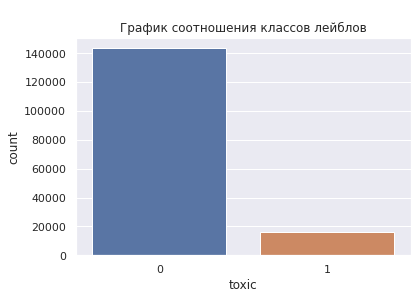

In [ ]:
print('Соотношение классов')
print(df['toxic'].value_counts())
sns.set()
plt.title("\nГрафик соотношения классов лейблов")
sns.countplot(df['toxic'])
plt.show()

### Вывод
- В нашем распоряжении данные (тексты на английском языке), состоящие из признака (комментарии) и целевого признака (лейбл токсичности комментария). 
- Данные без пропусков, без дубликатов. 
- Имеются мусорные спец. символы. 
- Имеется сильный дисбаланс в лейблах.

## Проведем стемминг и очистку текста от спец символов

Проведем стемминг (поиск основы словоформы) с очисткой от специальных символов (при помощи SnowballStemmer и регулярного выражения)

In [ ]:
%%time
# Создадим функцию для очистки текта от мусорных символов
def make_clear_text(text):
    clear_text = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())
    return clear_text

df['text_stem'] = (df['text'].apply(make_clear_text))
display(df)

,text,toxic,text_stem
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


CPU times: user 2.05 s, sys: 48.9 ms, total: 2.1 s
Wall time: 2.11 s


In [ ]:
%%time
# Создадим функцию для стемминга


def make_stem(text):
    english_stemmer = SnowballStemmer('english')

    stem_list = []
    for word in text.split():
        stem_list.append(english_stemmer.stem(word))
    stem = " ".join(stem_list)
    return stem

df['text_stem'] = df['text_stem'].apply(make_stem)


display(df)

,text,toxic,text_stem
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be asham of yourself that is a horr...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual articl for prostit...
159569,And it looks like it was actually you who put ...,0,and it look like it was actual you who put on ...


CPU times: user 2min 4s, sys: 297 ms, total: 2min 5s
Wall time: 2min 5s


Текст очистили от мусорных символов.

Разделим исходный данные на тренировочную и тестовую выборки.

In [ ]:
train, test = train_test_split(df, test_size = 0.1, random_state = 1)

Создадам корпус слов, привядя к кодировки UTF-8 (признак) и целевой признак

In [ ]:
corpus_train = train['text_stem'].values.astype('U')
target_train = train['toxic']

Проведем кодирование (трансформирование) слов в цифровую матрицу.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Мы будем использовать словарь стоп-слов, чтобы неприемлимые комментарии отправлялись на модерацию.

In [ ]:
%%time
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
display(count_tf_idf)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

corpus_test = test['text_stem'].values.astype('U')
target_test = test['toxic']
tf_idf_test = count_tf_idf.transform(corpus_test)
tf_idf_test.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

CPU times: user 11 s, sys: 310 ms, total: 11.3 s
Wall time: 11.3 s


In [ ]:
print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (143613, 123937)


# 2. Обучение

Мы обучим модели, которые справляются с цифрами матрицами и текстами:
- Логистическую регрессию LogisticRegression
- Предобученную модель BERT (Bidirectional Encoder Representations from Transformers - Двунаправленные представления кодировщика от Transformers)

## LogisticRegression

Подберем гиперпараметры при помощью GridSearchCV

In [ ]:
%%time

estimator = LogisticRegression(class_weight='balanced', random_state=1, solver = 'liblinear', max_iter = 100)

# Create hyperparameter options
hyperparameters = {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                   'penalty': ['l1', 'l2']}

# Create GridSearchCV search 5-fold cross validation
clf = GridSearchCV(estimator, hyperparameters, 
                   scoring = 'f1', 
                   cv=5, verbose=0, n_jobs=-1)

# Fit GridSearchCV search
best_model = clf.fit(tf_idf_train, target_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
clf_best = best_model.best_params_
best_score = best_model.best_score_
 
print('Best params = ', clf_best)
print('best_score = ', best_score)

Best Penalty: l2
Best C: 7
Best params =  {'C': 7, 'penalty': 'l2'}
best_score =  0.7631509711950086
CPU times: user 10.4 s, sys: 6.12 s, total: 16.5 s
Wall time: 6min 39s


Оптимальные гиперпараметры:
- Best params =  {'C': 7, 'penalty': 'l2'}
- best_score =  0.7619103949910186


Обучим модель LogisticRegression, присвоим сбалансированноть весов.

In [ ]:
%%time
model_LogisticRegression = LogisticRegression(class_weight='balanced', 
                                              random_state=1, 
                                              solver = 'liblinear', 
                                              max_iter = 100,
                                              C = 7,
                                              penalty = 'l2',
                                              n_jobs = -1)
model_LogisticRegression.fit(tf_idf_train, target_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 7.32 s, sys: 5.22 s, total: 12.5 s
Wall time: 6.46 s


Сделаем предсказания и вычислим метрику качесва модели F1-score.

In [ ]:
pred_train = model_LogisticRegression.predict(tf_idf_train)
print('f1_score train:', f1_score(target_train, pred_train))
pred_test = model_LogisticRegression.predict(tf_idf_test)
print('f1_score test:', f1_score(target_test, pred_test))

f1_score train: 0.8835454684864285
f1_score test: 0.7673847832015273


### Вывод

На логистической регресии мы получили качество F1-метрики:
**f1_score test: 0.767**

Это удовлетворяет условию задачи.

## BERT

Установим библиотеку Transformers

In [ ]:
!pip install transformers

In [ ]:
# for BERT
import torch
import torch.nn as nn
import transformers
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast
# specify GPU
device = torch.device("cuda")

Возьмем  предобученную модель BERT (от англ. Bidirectional Encoder Representations from Transformers, «двунаправленная нейронная сеть-кодировщик») — нейронная сеть для создания модели языка. 

Из нашего датасета возьмем часть данных, так как мощность аппартных устройств (объём памяти GPU) не позволяет нам произвести обучение модели на полных данных.

In [ ]:
df = pd.read_csv('toxic_comments.csv')
df = df.sample(n = 45000, random_state = 1)

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['toxic'], 
                                                                    random_state=1, 
                                                                    test_size=0.2, 
                                                                    stratify=df['toxic'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=1, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


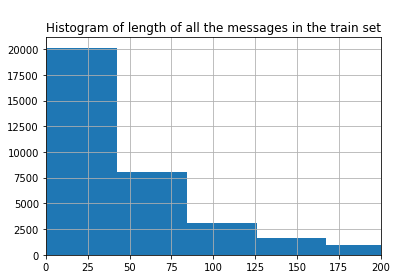

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
plt.title('\nHistogram of length of all the messages in the train set')
plt.xlim(0, 200)
plt.grid(True)
plt.show()

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.55772448 4.83091787]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 7

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
%%time
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 7
  Batch    50  of  1,125.
  Batch   100  of  1,125.
  Batch   150  of  1,125.
  Batch   200  of  1,125.
  Batch   250  of  1,125.
  Batch   300  of  1,125.
  Batch   350  of  1,125.
  Batch   400  of  1,125.
  Batch   450  of  1,125.
  Batch   500  of  1,125.
  Batch   550  of  1,125.
  Batch   600  of  1,125.
  Batch   650  of  1,125.
  Batch   700  of  1,125.
  Batch   750  of  1,125.
  Batch   800  of  1,125.
  Batch   850  of  1,125.
  Batch   900  of  1,125.
  Batch   950  of  1,125.
  Batch 1,000  of  1,125.
  Batch 1,050  of  1,125.
  Batch 1,100  of  1,125.

Evaluating...
  Batch    50  of    141.
  Batch   100  of    141.

Training Loss: 0.638
Validation Loss: 0.597

 Epoch 2 / 7
  Batch    50  of  1,125.
  Batch   100  of  1,125.
  Batch   150  of  1,125.
  Batch   200  of  1,125.
  Batch   250  of  1,125.
  Batch   300  of  1,125.
  Batch   350  of  1,125.
  Batch   400  of  1,125.
  Batch   450  of  1,125.
  Batch   500  of  1,125.
  Batch   550  of  1,125.
  

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4034
           1       0.44      0.78      0.56       466

    accuracy                           0.87      4500
   macro avg       0.71      0.83      0.74      4500
weighted avg       0.92      0.87      0.89      4500



In [ ]:
print('f1_score test:', f1_score(test_y, preds))

f1_score test: 0.5608055770720372


### Вывод
Качество модели BERT **f1_score test: 0.56**

## Dummy модель

Для проверки адекватности моделей сравним качесво с Dummy моделью.

In [ ]:
model_dummy = DummyClassifier()
model_dummy.fit(train_text, train_labels)
prediction_dummy = model_dummy.predict(test_text)
print('F1 для Dummy модели составил ', round(f1_score(test_labels, prediction_dummy),2))

F1 для Dummy модели составил  0.11


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Качесвто Dummy модели ... это ниже качества наших моджелей, что означает, что наши модели адекватны.

# 3. Выводы

Мы провели обучение моделей, которые ищут токсичные комментарии и отправляют их на модерацию.
В результате обучения моделей мы получили следующие показатели метрики оценки качества F1-score на тестовых данных:

- Модель LogisticRegression F1 - score: 0.76
- Модель BERT F1 - score: 0.56

Для сайта мы предложим модель LogisticRegression, она показала высокое качество и быструю скорость обучения.